## 1. Импорт библиотек и модулей

In [ ]:
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
from PIL import Image
import os
from tqdm.notebook import tqdm
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import os
from torchvision.ops.boxes import nms
from google.colab.patches import cv2_imshow
from google.colab import drive, files
import time

plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Работа с датафреймами

Ссылки на наборы данных:


1.   https://universe.roboflow.com/lt/lt-jlx6n/dataset/1
2.   https://universe.roboflow.com/lt/crack2-slqd6/dataset/1
3.   https://universe.roboflow.com/muet-8lca7/welding-vokhe/dataset/1
4.   https://universe.roboflow.com/conit/welding-crack-model/dataset/2
5.   https://universe.roboflow.com/celebal-workspace/welding_detection_v2/dataset/1
6.   https://universe.roboflow.com/aoi-6cr6f/welding_defect/dataset/2
7.   https://universe.roboflow.com/celebal/welding-aiu6l/dataset/1



После распаковки архивов переименовываем train, test, valib в train_i, test_i, valib_i (1 <= i <= 4) соответственно и удаляем README файлы

In [ ]:
# !unzip '/content/drive/MyDrive/work/cr_pr_867.zip'

In [ ]:
# !unzip '/content/drive/MyDrive/work/cr_pr_1026.zip'

In [ ]:
# !unzip '/content/drive/MyDrive/work/cr_pr_93.zip'

In [ ]:
# !unzip '/content/drive/MyDrive/work/cr_pr_722.zip'

Сохраним все тренеровочные и тестовые изображения в папку train, валидационные - в valid

In [ ]:
# for i in range(1, 5):
#     for filename in os.listdir(f'/content/train_{i}'):
#         if filename[-3:] != 'csv':
#             image = Image.open(f'/content/train_{i}/{filename}')
#             image.save(f'/content/drive/MyDrive/work/train/{filename}')
#     for filename in os.listdir(f'/content/test_{i}'):
#         if filename[-3:] != 'csv':
#             image = Image.open(f'/content/test_{i}/{filename}')
#             image.save(f'/content/drive/MyDrive/work/train/{filename}')
#     for filename in os.listdir(f'/content/valid_{i}'):
#         if filename[-3:] != 'csv':
#             image = Image.open(f'/content/valid_{i}/{filename}')
#             image.save(f'/content/drive/MyDrive/work/valid/{filename}')

In [ ]:
# df_train = pd.concat([pd.read_csv('/content/train_1/_annotations.csv'), pd.read_csv('/content/test_1/_annotations.csv'),
#                       pd.read_csv('/content/train_2/_annotations.csv'), pd.read_csv('/content/test_2/_annotations.csv'),
#                       pd.read_csv('/content/train_3/_annotations.csv'), pd.read_csv('/content/test_3/_annotations.csv'),
#                       pd.read_csv('/content/train_4/_annotations.csv'), pd.read_csv('/content/test_4/_annotations.csv')], ignore_index=True)

# df_valid = pd.concat([pd.read_csv('/content/valid_1/_annotations.csv'),
#                       pd.read_csv('/content/valid_2/_annotations.csv'),
#                       pd.read_csv('/content/valid_3/_annotations.csv'),
#                       pd.read_csv('/content/valid_4/_annotations.csv')], ignore_index=True)

In [ ]:
# df_train.to_csv('/content/drive/MyDrive/work/df_train.csv', index=False)
# df_valid.to_csv('/content/drive/MyDrive/work/df_valid.csv', index=False)

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/work/df_train.csv')
df_valid = pd.read_csv('/content/drive/MyDrive/work/df_valid.csv')

In [ ]:
def new_col(val):
    return [1 for i in range(len(val))]

In [ ]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Screenshot-2022-12-05-231137_jpeg_jpg.rf.4aaf1...,640,640,1,221,203,405,322
1,imagesyj_jpeg_jpg.rf.4a5c31a5a239f985516637cd8...,640,640,0,289,7,353,411
2,imagesyj_jpeg_jpg.rf.4a5c31a5a239f985516637cd8...,640,640,3,299,218,347,401
3,Screenshot-2022-12-05-231053_jpeg_jpg.rf.4697a...,640,640,0,0,133,637,361
4,Screenshot-2022-12-05-231053_jpeg_jpg.rf.4697a...,640,640,1,308,191,350,264


In [ ]:
df_train.drop(df_train[df_train['class'] == 'good_welding'].index, axis = 0, inplace=True)
df_train.drop(df_train[df_train['class'] == 'bad_welding'].index, axis = 0, inplace=True)
df_train.drop(df_train[df_train['class'] == '0'].index, axis = 0, inplace=True)
df_train.drop(df_train[df_train['class'] == '2'].index, axis = 0, inplace=True)
df_train.drop(df_train[df_train['class'] == 'spatter'].index, axis = 0, inplace=True)
df_train.drop(df_train[df_train['class'] == 'undercut'].index, axis = 0, inplace=True)
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Screenshot-2022-12-05-231137_jpeg_jpg.rf.4aaf1...,640,640,1,221,203,405,322
2,imagesyj_jpeg_jpg.rf.4a5c31a5a239f985516637cd8...,640,640,3,299,218,347,401
4,Screenshot-2022-12-05-231053_jpeg_jpg.rf.4697a...,640,640,1,308,191,350,264
7,bad_weld_vid327_jpeg_jpg.rf.531ef4d1a40b25a5ed...,640,640,1,12,431,158,463
8,bad_weld_vid327_jpeg_jpg.rf.531ef4d1a40b25a5ed...,640,640,1,192,430,340,494


In [ ]:
# создание новой колонки bboxes, являющейся списком числовых признаков xmin, ymin, xmax, ymax
df_train['boxes'] = [[df_train.iloc[i]['xmin'], df_train.iloc[i]['ymin'],
                      df_train.iloc[i]['xmax'], df_train.iloc[i]['ymax']] for i in range(df_train.count()[0])]
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,boxes
0,Screenshot-2022-12-05-231137_jpeg_jpg.rf.4aaf1...,640,640,1,221,203,405,322,"[221, 203, 405, 322]"
2,imagesyj_jpeg_jpg.rf.4a5c31a5a239f985516637cd8...,640,640,3,299,218,347,401,"[299, 218, 347, 401]"
4,Screenshot-2022-12-05-231053_jpeg_jpg.rf.4697a...,640,640,1,308,191,350,264,"[308, 191, 350, 264]"
7,bad_weld_vid327_jpeg_jpg.rf.531ef4d1a40b25a5ed...,640,640,1,12,431,158,463,"[12, 431, 158, 463]"
8,bad_weld_vid327_jpeg_jpg.rf.531ef4d1a40b25a5ed...,640,640,1,192,430,340,494,"[192, 430, 340, 494]"


In [ ]:
# cоздание для каждого изображения единого списка, включающего в себя координаты всех боксов этого изображения
df_train_dict = {}
for i in range(df_train.shape[0]):
  if df_train.iloc[i]['filename'] not in df_train_dict.keys():
    df_train_dict[df_train.iloc[i]['filename']] = []
for i in range(df_train.shape[0]):
  if df_train.iloc[i]['filename'] in df_train_dict.keys():
    # боксы, две крайние точки которых имеют равные значения абсцисс или ординат, игнорируются, так как они являются линиями
    if df_train.iloc[i]['boxes'][0] != df_train.iloc[i]['boxes'][2] and df_train.iloc[i]['boxes'][1] != df_train.iloc[i]['boxes'][3]:
        df_train_dict[df_train.iloc[i]['filename']].append(df_train.iloc[i]['boxes'])
df_train = pd.DataFrame({'filename': df_train_dict.keys(), 'boxes': df_train_dict.values()})
df_train.head()

,filename,boxes
0,Screenshot-2022-12-05-231137_jpeg_jpg.rf.4aaf1...,"[[221, 203, 405, 322]]"
1,imagesyj_jpeg_jpg.rf.4a5c31a5a239f985516637cd8...,"[[299, 218, 347, 401]]"
2,Screenshot-2022-12-05-231053_jpeg_jpg.rf.4697a...,"[[308, 191, 350, 264]]"
3,bad_weld_vid327_jpeg_jpg.rf.531ef4d1a40b25a5ed...,"[[12, 431, 158, 463], [192, 430, 340, 494], [4..."
4,bad_weld_vid693_jpeg_jpg.rf.4b0e91c38e994ff348...,"[[263, 255, 601, 291]]"


Аналогичную работу проведем с валидационным датафреймом

In [ ]:
df_valid.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,0,282,258,369,320
1,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,3,312,285,320,303
2,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,3,339,293,359,311
3,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,2,404,301,505,373
4,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,2,170,225,246,277


In [ ]:
df_valid.drop(df_valid[df_valid['class'] == 'good_welding'].index, inplace=True)
df_valid.drop(df_valid[df_valid['class'] == 'bad_welding'].index, inplace=True)
df_valid.drop(df_valid[df_valid['class'] == 0].index, inplace=True)
df_valid.drop(df_valid[df_valid['class'] == 2].index, inplace=True)
df_valid.drop(df_valid[df_valid['class'] == 'spatter'].index, inplace=True)
df_valid.drop(df_valid[df_valid['class'] == 'undercut'].index, inplace=True)
df_valid.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,0,282,258,369,320
1,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,3,312,285,320,303
2,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,3,339,293,359,311
3,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,2,404,301,505,373
4,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,2,170,225,246,277


In [ ]:
# создание новой колонки bboxes, являющейся списком числовых признаков xmin, ymin, xmax, ymax
df_valid['boxes'] = [[df_valid.iloc[i]['xmin'], df_valid.iloc[i]['ymin'],
                      df_valid.iloc[i]['xmax'], df_valid.iloc[i]['ymax']] for i in range(df_valid.count()[0])]
df_valid.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,boxes
0,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,0,282,258,369,320,"[282, 258, 369, 320]"
1,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,3,312,285,320,303,"[312, 285, 320, 303]"
2,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,3,339,293,359,311,"[339, 293, 359, 311]"
3,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,2,404,301,505,373,"[404, 301, 505, 373]"
4,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,640,640,2,170,225,246,277,"[170, 225, 246, 277]"


In [ ]:
# cоздание для каждого изображения единого списка, включающего в себя координаты всех боксов этого изображения
df_valid_dict = {}
for i in range(df_valid.shape[0]):
  if df_valid.iloc[i]['filename'] not in df_valid_dict.keys():
    df_valid_dict[df_valid.iloc[i]['filename']] = []
for i in range(df_valid.shape[0]):
  if df_valid.iloc[i]['filename'] in df_valid_dict.keys():
    # боксы, две крайние точки которых имеют равные значения абсцисс или ординат, игнорируются, так как они являются линиями
    if df_valid.iloc[i]['boxes'][0] != df_valid.iloc[i]['boxes'][2] and df_valid.iloc[i]['boxes'][1] != df_valid.iloc[i]['boxes'][3]:
        df_valid_dict[df_valid.iloc[i]['filename']].append(df_valid.iloc[i]['boxes'])
df_valid = pd.DataFrame({'filename': df_valid_dict.keys(), 'boxes': df_valid_dict.values()})
df_valid.head()

,filename,boxes
0,bad_weld_vid259_jpeg_jpg.rf.49188ba93ea2244852...,"[[282, 258, 369, 320], [312, 285, 320, 303], [..."
1,Screenshot-2022-12-05-230040_jpeg_jpg.rf.3d335...,"[[217, 121, 303, 444], [120, 107, 198, 133]]"
2,good-tig-welds_16_jpeg_jpg.rf.3de3ff6eb96a14de...,"[[432, 86, 496, 301], [253, 283, 427, 389]]"
3,good_weld_vid999_jpeg_jpg.rf.5222ef52926f39645...,"[[52, 298, 200, 505], [209, 127, 325, 317]]"
4,good_weld_vid1947_jpeg_jpg.rf.58503b70f98d39e7...,"[[62, 260, 486, 528]]"


## 3. DataLoader

In [ ]:
# создание класса Defect_Dataset
class Defect_Dataset(Dataset):
    def __init__(self, dataframe, path, transforms=None):
        self.df = dataframe
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        filename, boxes = self.df.iloc[index]
        image = cv2.imread(os.path.join(self.path, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor([1 for i in range(boxes.shape[0])], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([index])

        if self.transforms:
            sample = self.transforms(image = image,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image, target

Выведем рандомную картинку из тренировочного датафрейма с изображенными на ней боксами

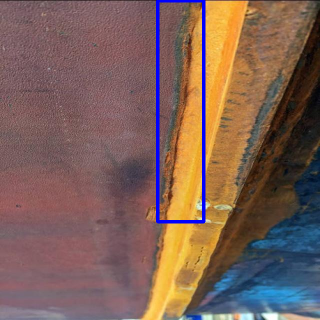

In [ ]:
path = os.path.join('/content/drive/MyDrive/work/train', df_train.loc[11, 'filename'])
iamge = cv2.imread(path)
boxes =  df_train.loc[11, 'boxes']
for box in boxes:
    cv2.rectangle(iamge,
        (int(box[0]), int(box[1])),
        (int(box[2]), int(box[3])),
        (255, 0, 0), 5)
width = int(iamge.shape[1] * 0.5)
height = int(iamge.shape[0] * 0.5)
dim = (width, height)
iamge = cv2.resize(iamge, dim)
cv2_imshow(iamge)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

In [ ]:
# инициализация датасетов
ds_train = Defect_Dataset(df_train, '/content/drive/MyDrive/work/train', get_train_transform())
ds_valid = Defect_Dataset(df_valid, '/content/drive/MyDrive/work/valid', get_valid_transform())

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

# инициализация даталоадеров
dl_train = torch.utils.data.DataLoader(ds_train,
                                       batch_size=8,
                                       shuffle=True,
                                       num_workers=0,
                                       collate_fn=collate_fn)
dl_valid = torch.utils.data.DataLoader(ds_valid,
                                       batch_size=8,
                                       shuffle=False,
                                       num_workers=0,
                                       collate_fn=collate_fn)

## 4. Загрузка модели, ее обучение и оценка

In [ ]:
# определение устройства
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
# загрузка модели
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 1 класс принадлежит сигаретам, другой - фону
num_classes = 2

# количество входных в классификатор признаков
in_features = model.roi_heads.box_predictor.cls_score.in_features

# заменияем обученную голову на новую
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 231MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
# задание оптимизатора
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

train_loss_hist = Averager()
valid_loss_hist = Averager()
train_itr = 1
valid_itr = 1
save_plots_epoch = 2
num_epochs = 10
train_loss_list = []
valid_loss_list = []

In [ ]:
# фуннкция обучения
def train(dl_train, model):
    print('Training')
    global train_itr
    global train_loss_list

    prog_bar = tqdm(dl_train, total=len(dl_train))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return train_loss_list

# фуннкция валидации
def valid(dl_valid, model):
    print('Validating')
    global valid_itr
    global valid_loss_list

    prog_bar = tqdm(dl_valid, total=len(dl_valid))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        valid_loss_list.append(loss_value)
        valid_loss_hist.send(loss_value)
        valid_itr += 1
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return valid_loss_list

In [ ]:
for epoch in range(num_epochs):
    print(f"\nEPOCH {epoch+1} of {num_epochs}")

    train_loss_hist.reset()
    valid_loss_hist.reset()

    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    start = time.time()

    train_loss = train(dl_train, model)
    val_loss = valid(dl_valid, model)

    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch} validation loss: {valid_loss_hist.value:.3f}")

    end = time.time()

    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    if (epoch+1) % save_plots_epoch == 0:
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"/content/drive/MyDrive/work/train_loss_{epoch+1}.png")
        figure_2.savefig(f"/content/drive/MyDrive/work/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')

    if (epoch+1) == num_epochs:
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"/content/drive/MyDrive/work/train_loss_{epoch+1}.png")
        figure_2.savefig(f"/content/drive/MyDrive/work/valid_loss_{epoch+1}.png")
        torch.save(model.state_dict(), f"/content/drive/MyDrive/work/model{epoch+1}.pth")

    plt.close('all')


EPOCH 1 of 10
Training


  0%|          | 0/78 [00:00<?, ?it/s]

Validating


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch #0 train loss: 0.338
Epoch #0 validation loss: 0.360
Took 13.006 minutes for epoch 0

EPOCH 2 of 10
Training


  0%|          | 0/78 [00:00<?, ?it/s]

Validating


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch #1 train loss: 0.270
Epoch #1 validation loss: 0.374
Took 2.292 minutes for epoch 1
SAVING PLOTS COMPLETE...

EPOCH 3 of 10
Training


  0%|          | 0/78 [00:00<?, ?it/s]

Validating


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch #2 train loss: 0.249
Epoch #2 validation loss: 0.348
Took 2.291 minutes for epoch 2

EPOCH 4 of 10
Training


  0%|          | 0/78 [00:00<?, ?it/s]

Validating


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch #3 train loss: 0.228
Epoch #3 validation loss: 0.381
Took 2.296 minutes for epoch 3
SAVING PLOTS COMPLETE...

EPOCH 5 of 10
Training


  0%|          | 0/78 [00:00<?, ?it/s]

Validating


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch #4 train loss: 0.214
Epoch #4 validation loss: 0.366
Took 2.295 minutes for epoch 4

EPOCH 6 of 10
Training


  0%|          | 0/78 [00:00<?, ?it/s]

Validating


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch #5 train loss: 0.202
Epoch #5 validation loss: 0.351
Took 2.287 minutes for epoch 5
SAVING PLOTS COMPLETE...

EPOCH 7 of 10
Training


  0%|          | 0/78 [00:00<?, ?it/s]

Validating


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch #6 train loss: 0.188
Epoch #6 validation loss: 0.380
Took 2.288 minutes for epoch 6

EPOCH 8 of 10
Training


  0%|          | 0/78 [00:00<?, ?it/s]

Validating


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch #7 train loss: 0.182
Epoch #7 validation loss: 0.363
Took 2.288 minutes for epoch 7
SAVING PLOTS COMPLETE...

EPOCH 9 of 10
Training


  0%|          | 0/78 [00:00<?, ?it/s]

Validating


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch #8 train loss: 0.171
Epoch #8 validation loss: 0.392
Took 2.288 minutes for epoch 8

EPOCH 10 of 10
Training


  0%|          | 0/78 [00:00<?, ?it/s]

Validating


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch #9 train loss: 0.163
Epoch #9 validation loss: 0.444
Took 2.290 minutes for epoch 9
SAVING PLOTS COMPLETE...


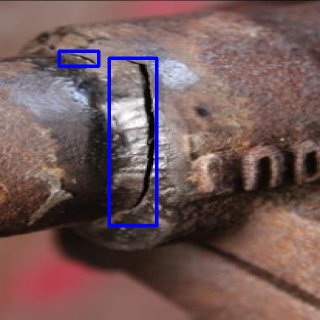

In [ ]:
def draw_predict(df_index, iou_threshold=0.1, threshold=0.8, scale_percent=25):
    model.eval()
    img = cv2.imread(os.path.join('/content/drive/MyDrive/work/valid', df_valid.loc[df_index, 'filename']))
    img_ = img / 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            cv2.rectangle(img,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (255, 0, 0), 5)
    width = int(img.shape[1] * 0.5)
    height = int(img.shape[0] * 0.5)
    dim = (width, height)
    img = cv2.resize(img, dim)
    cv2_imshow(img)
draw_predict(1, 0.1)